<a href="https://colab.research.google.com/github/usintec/image-segmentation-model/blob/main/image-segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [43]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-i_y_igg_
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-i_y_igg_
  Resolved https://github.com/albumentations-team/albumentations to commit 662190df63da5ed14ca14883ed20478c5fec8e83
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [44]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411 (from 1)
Receiving objects: 100% (411/411), 851.74 MiB | 20.59 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


In [45]:
# Some Common Imports

In [64]:
import sys
import torch
sys.path.append('/content/Road_seg_dataset')

# Task : 2 Setup Configurations

In [65]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

EPOCHS = 25
BATCH_SIZE = 8
LEARNING_RATE = 0.003
IMAGE_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

NUM_WORKERS = 4
PIN_MEMORY = True
LOAD_MODEL = False

In [66]:
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [67]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [69]:
row = df.iloc[4]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

print(f"Image Shape : {image.shape}")
print(f"Mask Shape : {mask.shape}")

Image Shape : (1500, 1500, 3)
Mask Shape : (1500, 1500)


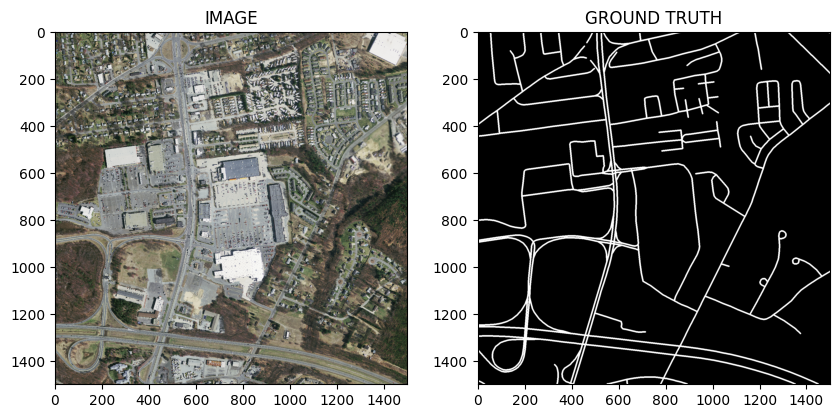

In [70]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [71]:
train_test_split = train_test_split(df, test_size=0.2, random_state=42)

train_df = train_test_split[0]
test_df = train_test_split[1]

# Task 3 : Augmentation Functions
albumentation documentation : https://albumentations.ai/docs/


In [72]:
import albumentations as A

In [73]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [74]:
from torch.utils.data import Dataset

In [79]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row  = self.df.iloc[index]
    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    #(h, w, c) => (c, h, w)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [80]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(test_df, get_valid_augs())

In [81]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 159
Size of Validset : 40


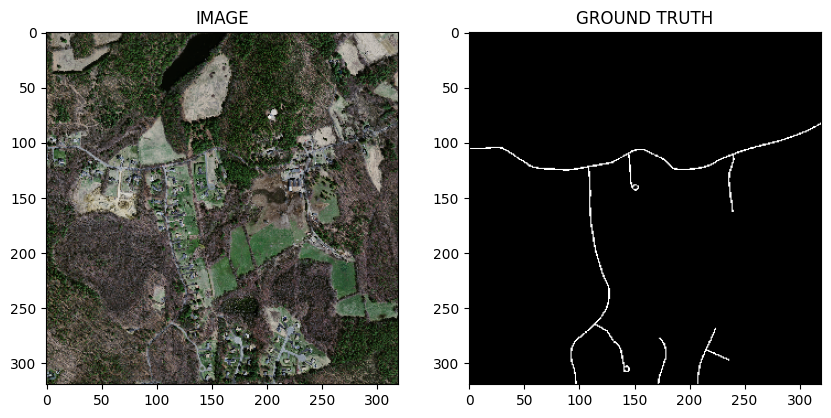

In [82]:
idx = 3
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [83]:
from torch.utils.data import DataLoader

In [84]:
trainLoader = DataLoader(
    dataset=trainset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
validLoader = DataLoader(
    dataset=validset,
    batch_size=BATCH_SIZE,
)

In [85]:
print(f"Number of batches in trainloader : {len(trainLoader)}")
print(f"Number of batches in validloader : {len(validLoader)}")

Number of batches in trainloader : 10
Number of batches in validloader : 3


In [86]:
for images, masks in trainLoader:
  print(f"Image batch shape : {images.shape}")
  print(f"Mask batch shape : {masks.shape}")
  break

Image batch shape : torch.Size([16, 3, 320, 320])
Mask batch shape : torch.Size([16, 1, 320, 320])
